In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import tf_silent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from pinn import PINN
from network import Network
from optimizer import L_BFGS_B

In [3]:

# # import tensorflow as tf

# # List available CUDA GPUs
# gpus = tf.config.list_physical_devices("GPU")
# print("GPUs:", gpus)


# if gpus:
#     gpu_index = 0
#     tf.config.set_visible_devices(gpus[gpu_index], 'GPU')
#     print("Set visible device to:", gpus[gpu_index])
# else:
#     print("No CUDA GPUs found! Check your CUDA/cuDNN installation and LD_LIBRARY_PATH.")

In [4]:
tf.config.list_logical_devices("GPU")

[]

In [5]:
def mass_cons(network, xy):
    """
    Compute u_x and v_y
    Args:
        xy: network input variables as ndarray.
    Returns:
        (u_x, v_y) as ndarray.
    """

    xy = tf.constant(xy)
    x, y = [ xy[..., i, tf.newaxis] for i in range(xy.shape[-1]) ]
    with tf.GradientTape(persistent=True) as g:
      g.watch(x)
      g.watch(y)

      u_v_p = network(tf.concat([x, y], axis=-1))
      u = u_v_p[..., 0, tf.newaxis]
      v = u_v_p[..., 1, tf.newaxis]
      p = u_v_p[..., 2, tf.newaxis]
    u_x = g.batch_jacobian(u, x)[..., 0]
    v_y = g.batch_jacobian(v, y)[..., 0]

    return u_x.numpy(), v_y.numpy()


In [6]:
def u_0(xy):
    """
    Initial wave form.
    Args:
        tx: variables (t, x) as tf.Tensor.
    Returns:
        u(t, x) as tf.Tensor.
    """

    x = xy[..., 0, None]
    y = xy[..., 1, None]


    return    4*y*(1 - y) 


In [7]:
# if __name__ == '__main__':
"""
Test the physics informed neural network (PINN) model
for the cavity flow governed by the steady Navier-Stokes equation.
"""

# number of training samples
num_train_samples = 5000
# number of test samples
num_test_samples = 200

# inlet flow velocity
u0 = 1
# density
rho = 1
# viscosity
mu = 2*1e-2
# Re = (L*u0*rho)/mu ==> rho/mu = 50

# build a core network model
network = Network().build()
network.summary()
# build a PINN model
pinn = PINN(network, rho=rho, mu=mu).build()

# Domain and circle data
x_f =2
x_ini=0
y_f=1
y_ini=0
Cx = 0.5
Cy = 0.5
a = 0.1
b = 0.1

xyt_circle = np.random.rand(num_train_samples, 2)
xyt_circle[...,0] = 2*(a)*xyt_circle[...,0] +(Cx-a)
xyt_circle[0:num_train_samples//2,1] = b*(1 - (xyt_circle[0:num_train_samples//2,0]-Cx)**2 / a**2)**0.5 + Cy
xyt_circle[num_train_samples//2:,1] = -b*(1 - (xyt_circle[num_train_samples//2:,0]-Cx)**2 / a**2)**0.5 + Cy

# create training input
xyt_eqn = np.random.rand(num_train_samples, 2)
xyt_eqn[...,0] = (x_f - x_ini)*xyt_eqn[...,0] + x_ini
xyt_eqn[...,1] = (y_f - y_ini)*xyt_eqn[...,1] + y_ini

for i in range(num_train_samples):
  while (xyt_eqn[i, 0] - Cx)**2/a**2 + (xyt_eqn[i, 1] - Cy)**2/b**2 < 1:
    xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand(1, 1) + x_ini
    xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand(1, 1) + y_ini

xyt_w1 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w1[..., 0] = (x_f - x_ini)*xyt_w1[...,0] + x_ini
xyt_w1[..., 1] =  y_ini          # y-position is 0 or 1

xyt_w2 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w2[..., 0] = (x_f - x_ini)*xyt_w2[...,0] + x_ini
xyt_w2[..., 1] =  y_f

xyt_out = np.random.rand(num_train_samples, 2)  # left-right boundaries
xyt_out[..., 0] = x_f

xyt_in = np.random.rand(num_train_samples, 2)
xyt_in[...,0] = x_ini

x_train = [xyt_eqn, xyt_w1, xyt_w2, xyt_out, xyt_in, xyt_circle]

# create training output
zeros = np.zeros((num_train_samples, 3))
#uv_bnd[..., 0] = -u0 * np.floor(xy_bnd[..., 0]) +1
#ones = np.ones((num_train_samples, 3))
#onze = np.random.rand(num_train_samples, 3)
#onze[...,0] = u0
#onze[...,1] = 0
#onze[...,2] = u0
a = u_0(tf.constant(xyt_in)).numpy()
b = np.zeros((num_train_samples, 1))
onze = np.random.permutation(np.concatenate([a,b,a],axis = -1))

y_train = [zeros, onze, zeros, zeros, zeros, zeros]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 48)                144       
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 48)                2352      
                                                                 
 dense_3 (Dense)             (None, 48)                2352      
                                                                 
 dense_4 (Dense)             (None, 3)                 147       
                                                                 
Total params: 7347 (28.70 KB)
Trainable params: 7347 (28.70 K

/tmp/ipykernel_2771829/4240836277.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand(1, 1) + x_ini
/tmp/ipykernel_2771829/4240836277.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand(1, 1) + y_ini


In [8]:
from optimizer import L_BFGS_B
# train the model using L-BFGS-B algorithm
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:   0%|          | 0/30000 [00:00<?, ?iter/s]

L-BFGS-B:  45%|████▌     | 13586/30000 [32:10<38:52,  7.04iter/s, loss=0.00486]  


keras.src.engine.functional.Functional

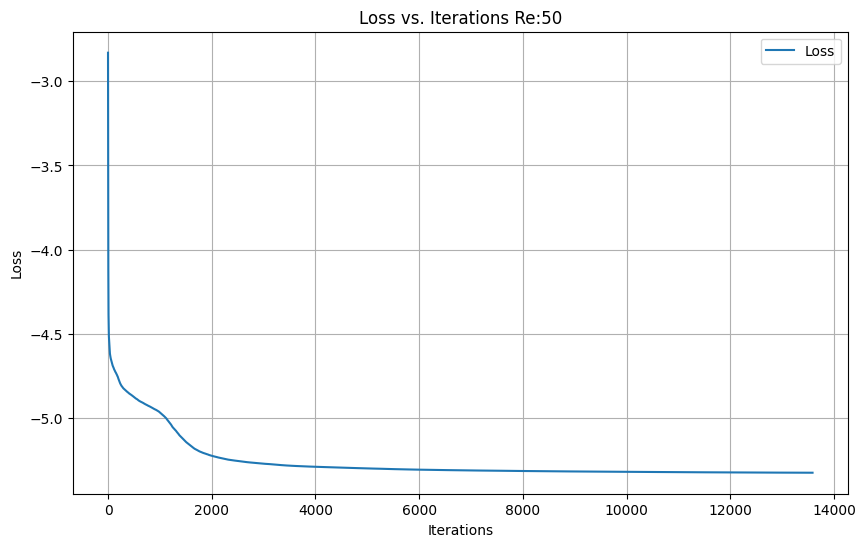

In [18]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(lbfgs.loss_history)), np.log(lbfgs.loss_history), label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations Re:50')
plt.legend()
plt.grid()
plt.savefig('loss_curve_Re50.png')
plt.show()

In [19]:
def plot_profiles(x, y, u, v, cross_sections):
    """
    Plot velocity profiles (u, v) along specified cross-sections.
    Args:
        x: x-array (meshgrid).
        y: y-array (meshgrid).
        u: u-array (velocity in x-direction).
        v: v-array (velocity in y-direction).
        cross_sections: List of cross-sections to plot. Each cross-section is a tuple (type, value).
                        'type' can be 'x' or 'y', and 'value' is the coordinate value.
                        Example: [('x', 0), ('y', 0), ('y', 1), ('x', 0.75)]
    """
    for section in cross_sections:
        section_type, value = section
        if section_type == 'x':  # Vertical line (constant x)
            idx = np.argmin(np.abs(x[0, :] - value))  # Find the closest x index
            plt.figure(figsize=(8, 6))
            plt.plot(y[:, idx], u[:, idx], label='u (x={})'.format(value))
            plt.plot(y[:, idx], v[:, idx], label='v (x={})'.format(value))
            plt.xlabel('y')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at x = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()
        elif section_type == 'y':  # Horizontal line (constant y)
            idx = np.argmin(np.abs(y[:, 0] - value))  # Find the closest y index
            plt.figure(figsize=(8, 6))
            plt.plot(x[idx, :], u[idx, :], label='u (y={})'.format(value))
            plt.plot(x[idx, :], v[idx, :], label='v (y={})'.format(value))
            plt.xlabel('x')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at y = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()

In [20]:

# create meshgrid coordinates (x, y) for test plots    

x = np.linspace(x_ini, x_f, num_test_samples)
y = np.linspace(y_ini, y_f, num_test_samples)
x, y = np.meshgrid(x, y)
xy = np.stack([x.flatten(), y.flatten()], axis=-1)
# predict (psi, p)
u_v_p = network.predict(xy, batch_size=len(xy))
u, v, p = [ u_v_p[..., i].reshape(x.shape) for i in range(u_v_p.shape[-1]) ]
# compute (u, v)
u = u.reshape(x.shape)
v = v.reshape(x.shape)
p = p.reshape(x.shape)


1/1 [==============================] - 0s 47ms/step


In [12]:
u.shape, v.shape, p.shape, x.shape, y.shape

((200, 200), (200, 200), (200, 200), (200, 200), (200, 200))

In [13]:
def contour(x, y, z, title, levels=200):
    """
    Contour plot.
    Args:
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
        circle_center: (x, y) center of the circle.
        circle_radius: radius of the circle.
    """
    circle_center = (0.5, 0.5)
    circle_radius = 0.1
    vmin = np.min(z)
    vmax = np.max(z)
    font1 = {'family':'serif','size':20}
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    ax = plt.gca()
    ax.set_aspect('equal')
    circle = plt.Circle(circle_center, circle_radius, fc='black', zorder=10)
    ax.add_patch(circle)
    plt.title(title, fontdict=font1)
    plt.xlabel("x", fontdict=font1)
    plt.ylabel("y", fontdict=font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)

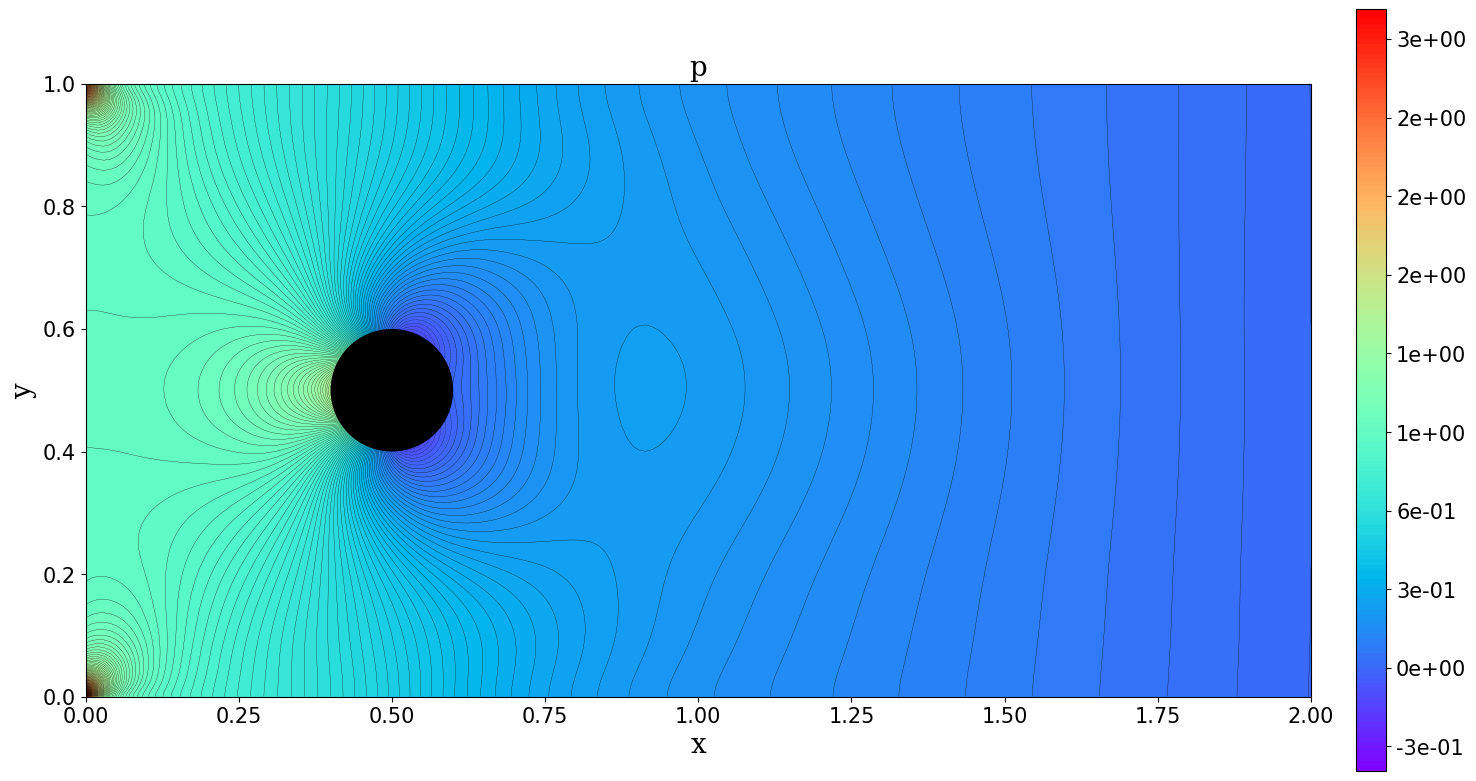

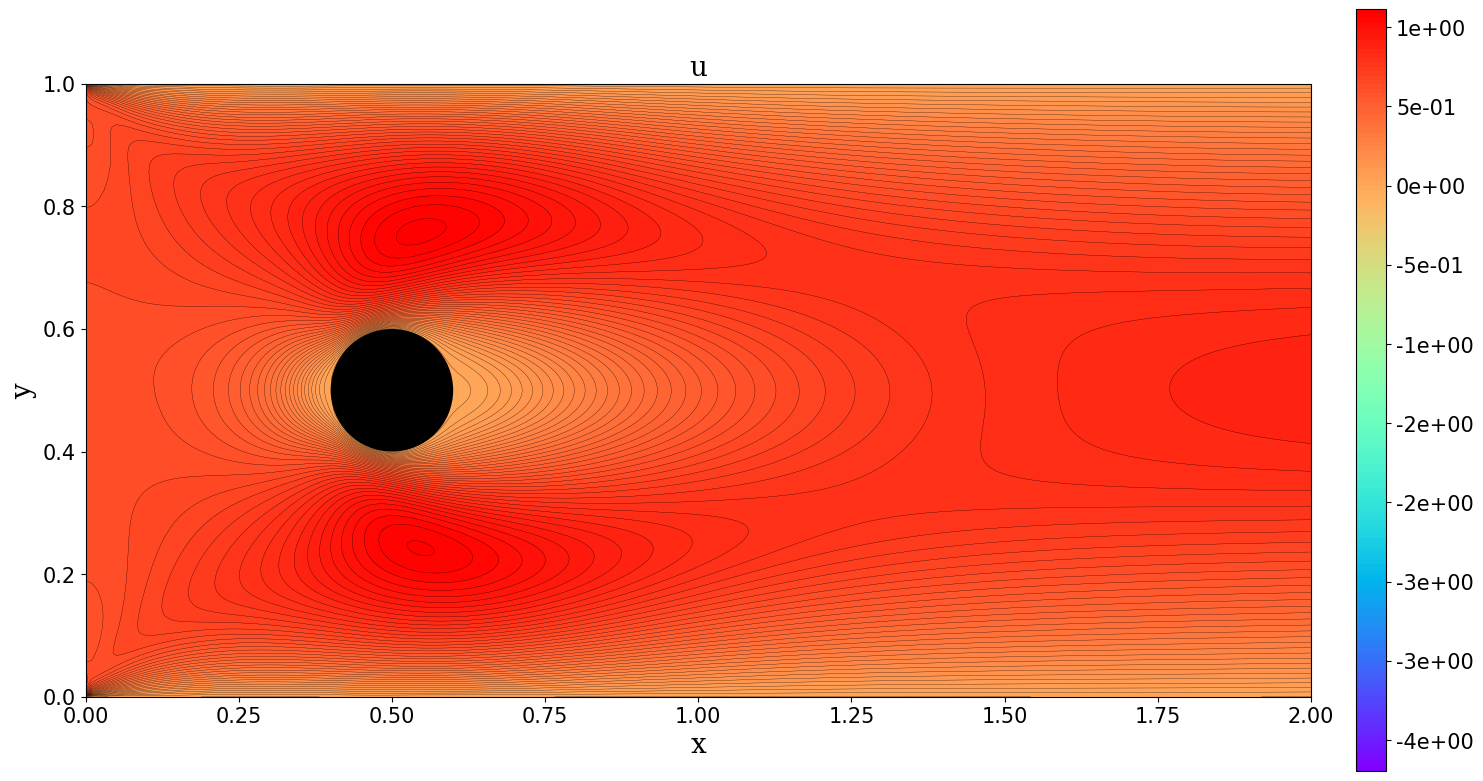

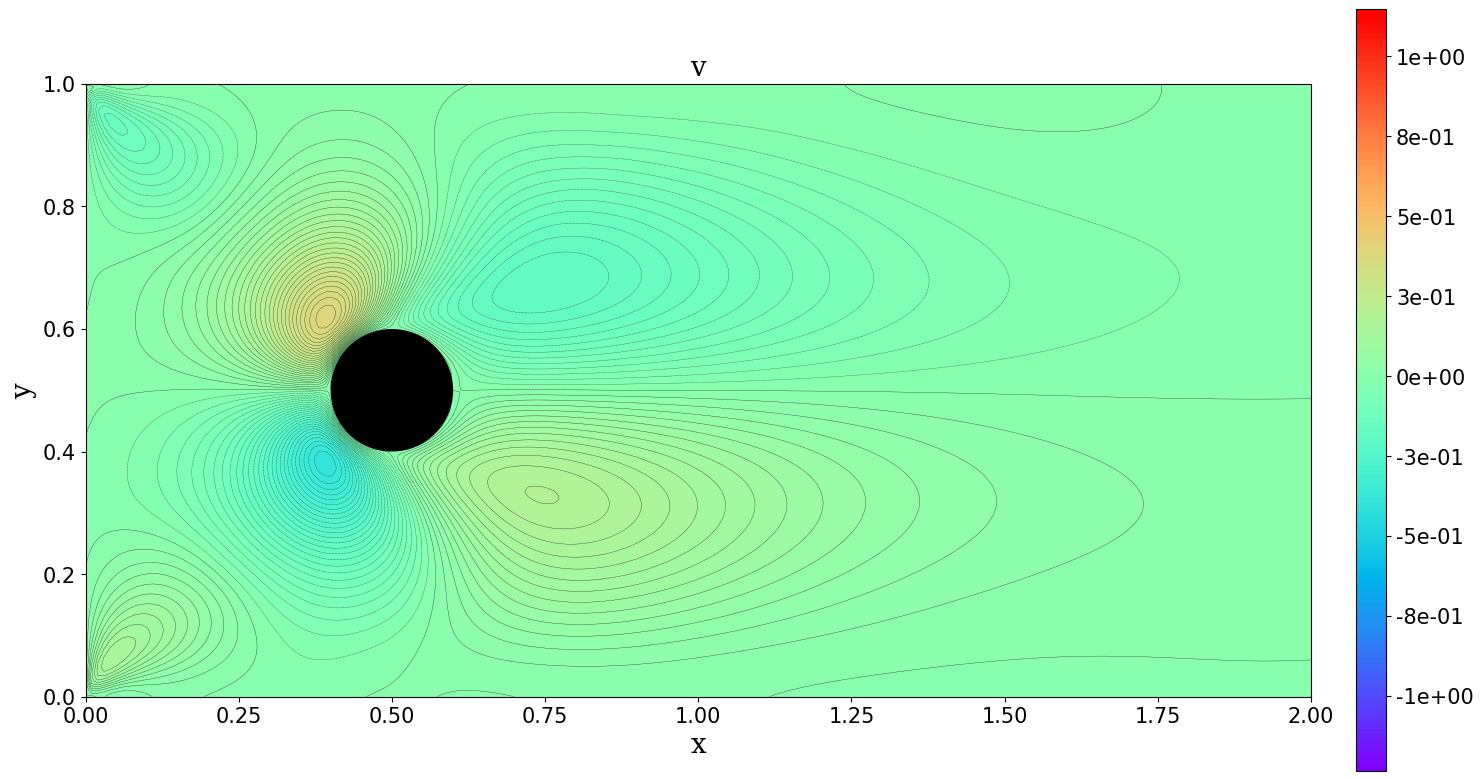

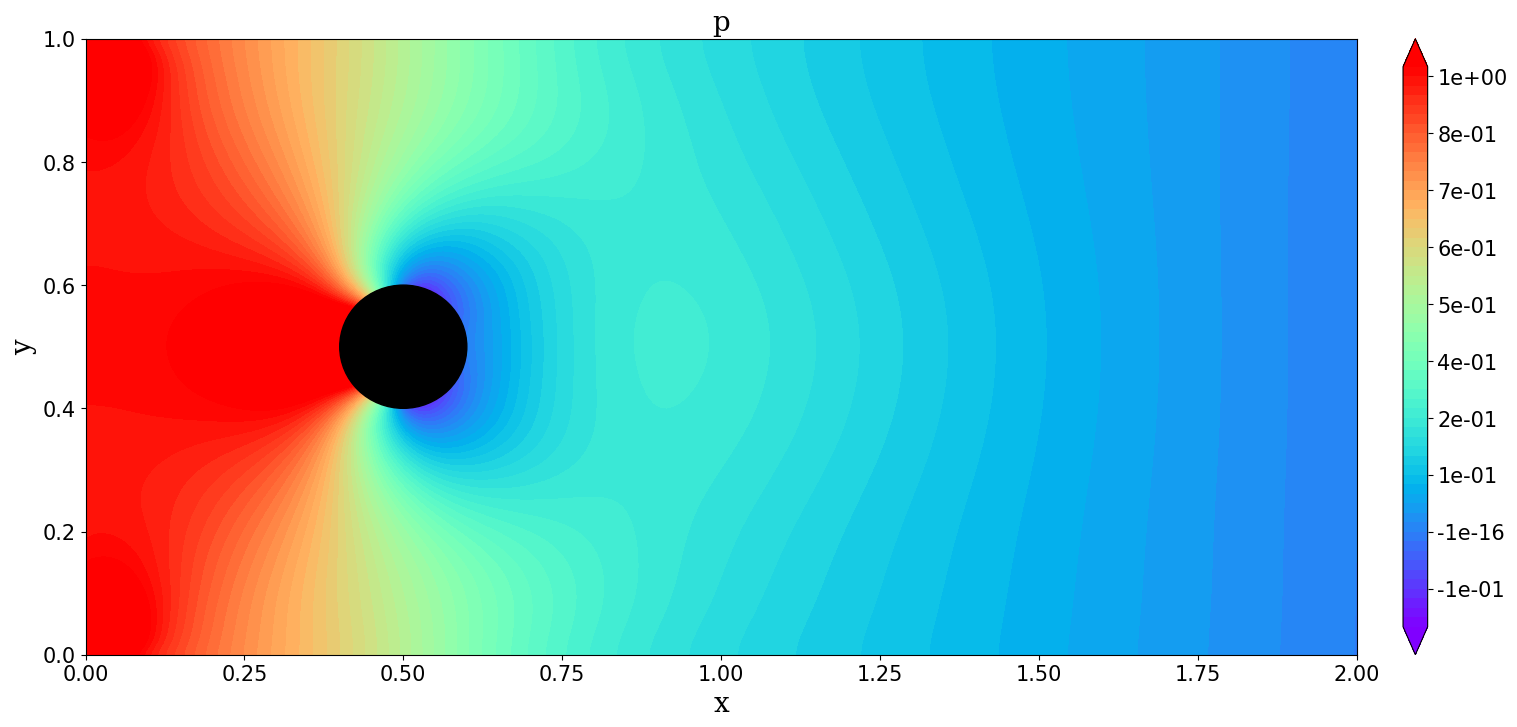

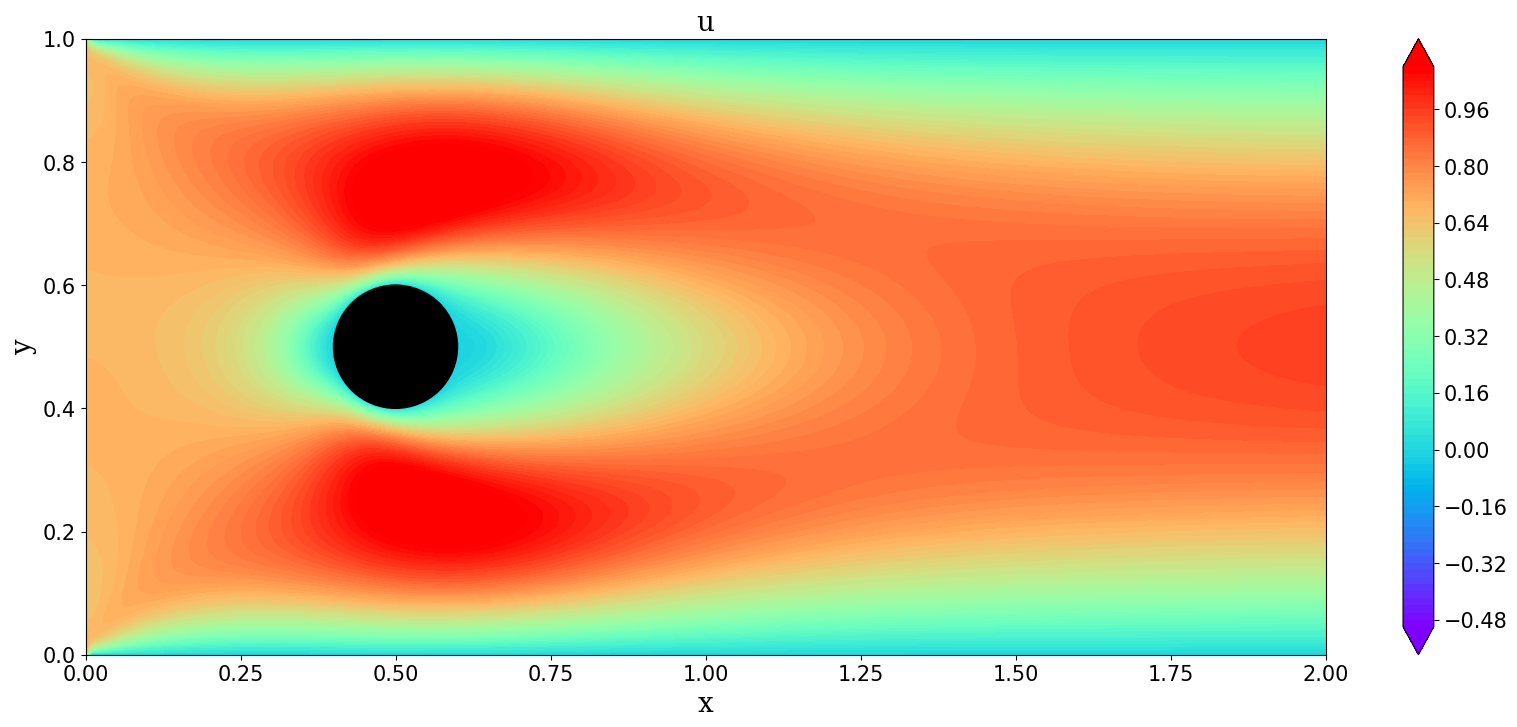

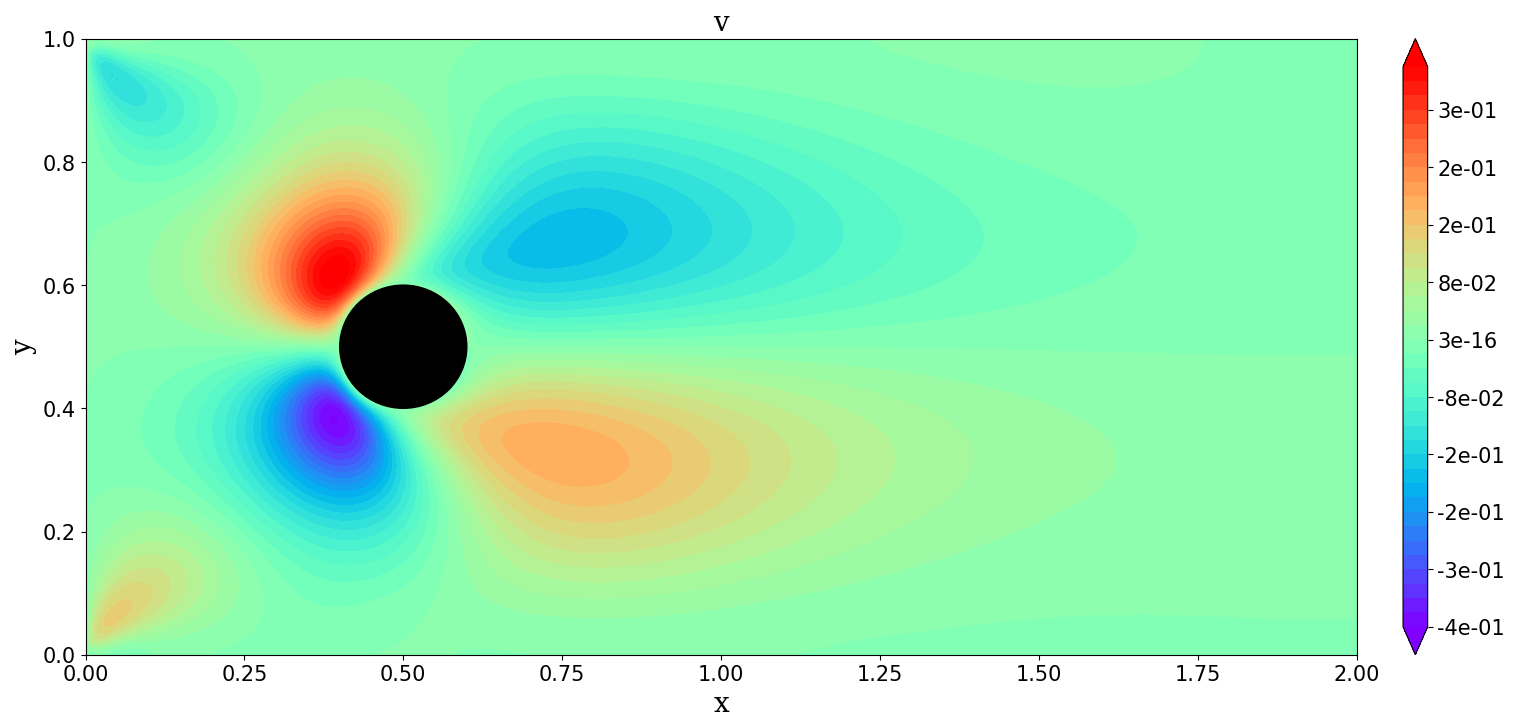

In [14]:

# plot test results
fig = plt.figure(figsize=(16, 8))
contour(x, y, p, 'p')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(16, 8))
contour(x, y, u, 'u')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(16, 8))
contour(x, y, v, 'v')
plt.tight_layout()
plt.show()


###########################
from matplotlib.patches import Circle
font1 = {'family':'serif','size':20}

fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
cf0 = ax0.contourf(x, y, p, np.arange(-0.2, 1, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
plt.title("p", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

###########################

fig0, ax0 = plt.subplots(1, 1, figsize=(20,8))
cf0 = ax0.contourf(x, y, u, np.arange(-0.5, 1.1, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, )
plt.title("u", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

###########################

fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
cf0 = ax0.contourf(x, y, v, np.arange(-0.4, 0.4, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
plt.title("v", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

############################ 


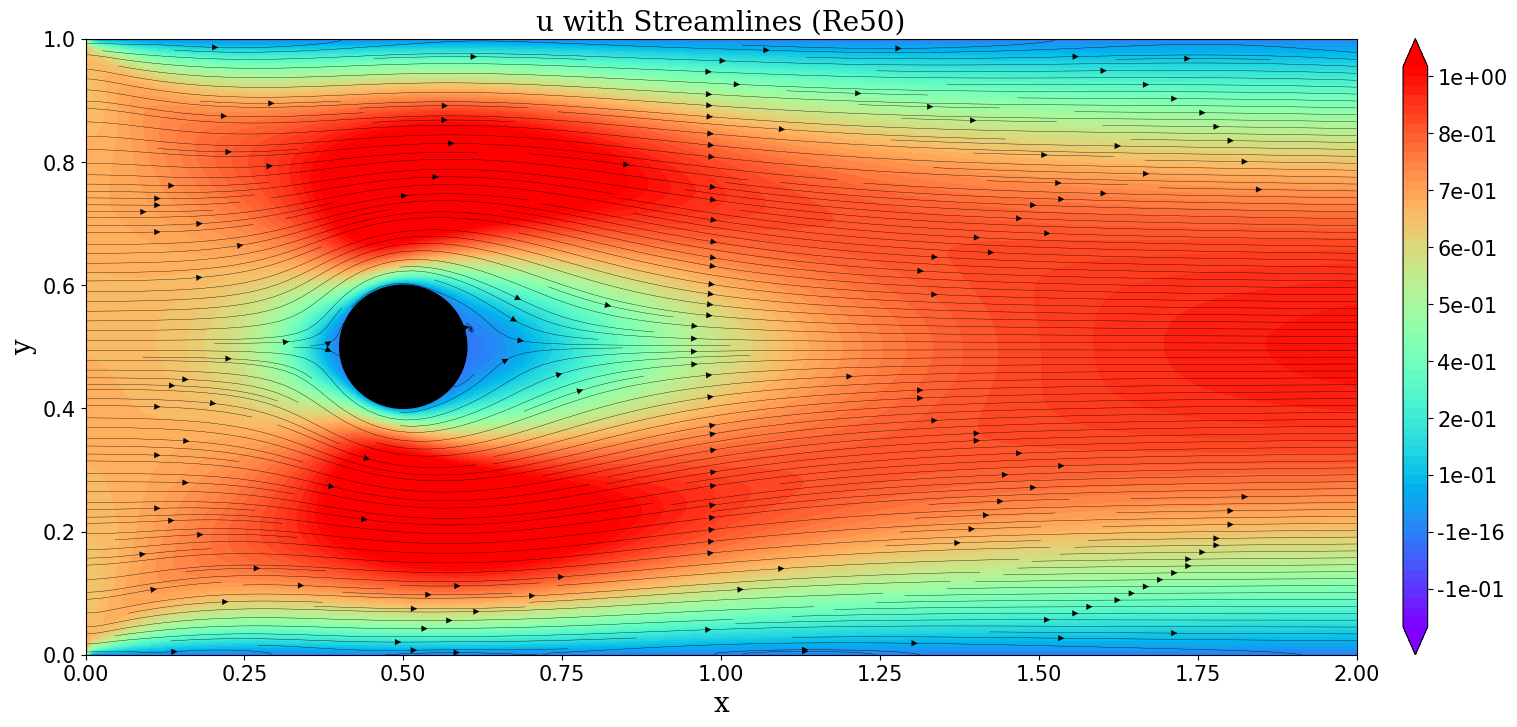

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

font1 = {'family':'serif','size':20}

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
# Contourf for pressure (or any scalar field)
cf = ax.contourf(x, y, u, np.arange(-0.2, 1, .02), extend='both', cmap='rainbow')
cbar = plt.colorbar(cf, pad=0.03, aspect=25, format='%.0e')
# Streamlines for velocity field
strm = ax.streamplot(x, y, u, v, color='k', density=3, linewidth=0.25)
# Add cylinder
ax.add_patch(Circle((0.5, 0.5), 0.1, color="black"))
plt.title("u with Streamlines (Re50)", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
cbar.ax.tick_params(labelsize=15)
plt.savefig('u_streamlines_Re50.png', dpi=300)
plt.show()

In [21]:
def plot_profiles(x, y, u, v, cross_sections, save_csv=False, prefix="u10", location="data/pinn_profiles/"):
    """
    Plot velocity profiles (u, v) along specified cross-sections and optionally save u profiles to CSV.
    Args:
        x: x-array (meshgrid).
        y: y-array (meshgrid).
        u: u-array (velocity in x-direction).
        v: v-array (velocity in y-direction).
        cross_sections: List of cross-sections to plot. Each cross-section is a tuple (type, value).
        save_csv: If True, save u profiles to CSV files.
        prefix: Prefix for CSV filenames.
    """
    for section in cross_sections:
        section_type, value = section
        if section_type == 'x':  # Vertical line (constant x)
            idx = np.argmin(np.abs(x[0, :] - value))  # Find the closest x index
            plt.figure(figsize=(8, 6))
            plt.plot(y[:, idx], u[:, idx], label='u (x={})'.format(value))
            plt.plot(y[:, idx], v[:, idx], label='v (x={})'.format(value))
            plt.xlabel('y')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at x = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()
            if save_csv:
                # Save u profile: y as 'x', u as 'u'
                df = pd.DataFrame({'x': y[:, idx], 'u': u[:, idx]})
                filename = f"{prefix}_{value}.csv"
                df.to_csv(location+prefix+"/"+filename, index=False)
        elif section_type == 'y':  # Horizontal line (constant y)
            idx = np.argmin(np.abs(y[:, 0] - value))  # Find the closest y index
            plt.figure(figsize=(8, 6))
            plt.plot(x[idx, :], u[idx, :], label='u (y={})'.format(value))
            plt.plot(x[idx, :], v[idx, :], label='v (y={})'.format(value))
            plt.xlabel('x')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at y = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()
            if save_csv:
                # Save u profile: x as 'x', u as 'u'
                df = pd.DataFrame({'x': x[idx, :], 'u': u[idx, :]})
                filename = f"{prefix}_y{value}.csv"
                df.to_csv(location+prefix+"/"+filename, index=False)

In [22]:
def plot_profiles(x, y, u, v, cross_sections):
    """
    Plot velocity profiles (u, v) along specified cross-sections.
    Args:
        x: x-array (meshgrid).
        y: y-array (meshgrid).
        u: u-array (velocity in x-direction).
        v: v-array (velocity in y-direction).
        cross_sections: List of cross-sections to plot. Each cross-section is a tuple (type, value).
                        'type' can be 'x' or 'y', and 'value' is the coordinate value.
                        Example: [('x', 0), ('y', 0), ('y', 1), ('x', 0.75)]
    """
    for section in cross_sections:
        section_type, value = section
        if section_type == 'x':  # Vertical line (constant x)
            idx = np.argmin(np.abs(x[0, :] - value))  # Find the closest x index
            plt.figure(figsize=(8, 6))
            plt.plot(y[:, idx], u[:, idx], label='u (x={})'.format(value))
            plt.plot(y[:, idx], v[:, idx], label='v (x={})'.format(value))
            plt.xlabel('y')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at x = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()
        elif section_type == 'y':  # Horizontal line (constant y)
            idx = np.argmin(np.abs(y[:, 0] - value))  # Find the closest y index
            plt.figure(figsize=(8, 6))
            plt.plot(x[idx, :], u[idx, :], label='u (y={})'.format(value))
            plt.plot(x[idx, :], v[idx, :], label='v (y={})'.format(value))
            plt.xlabel('x')
            plt.ylabel('Velocity')
            plt.title('Velocity Profiles at y = {}'.format(value))
            plt.legend()
            plt.grid()
            plt.show()

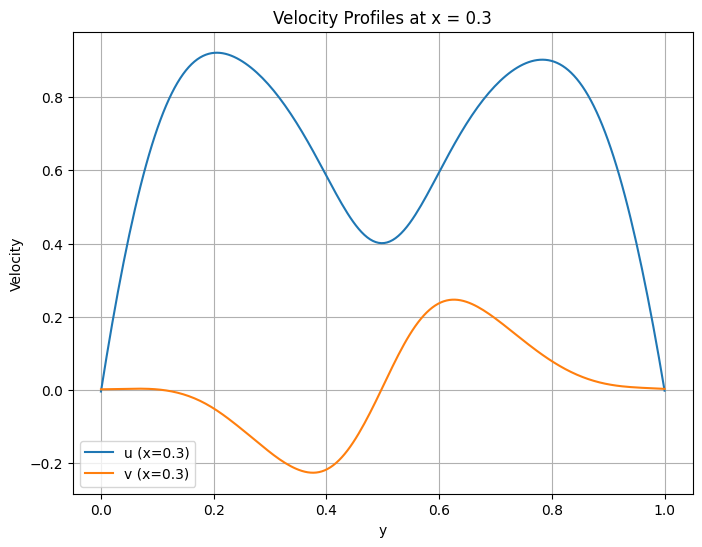

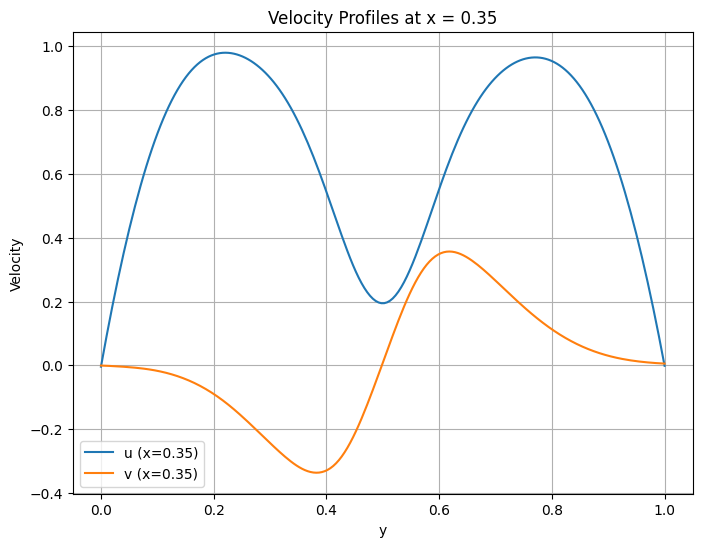

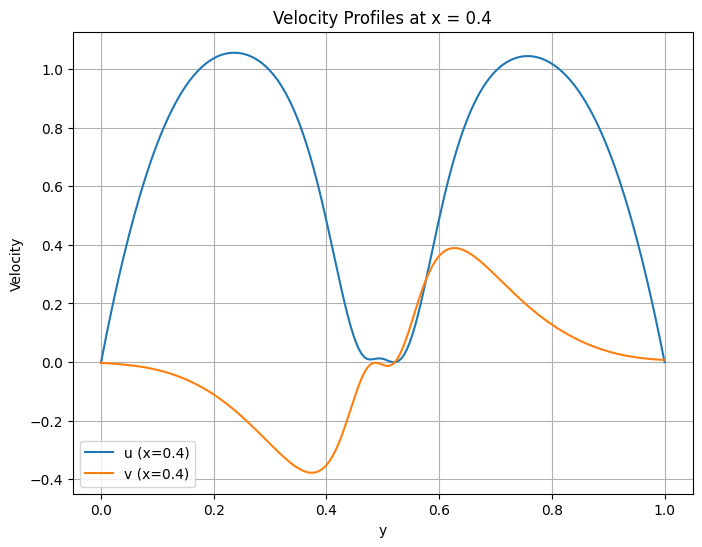

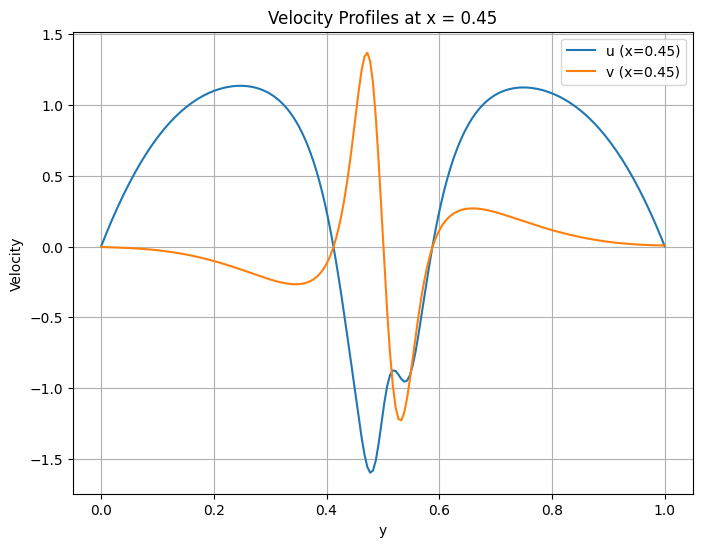

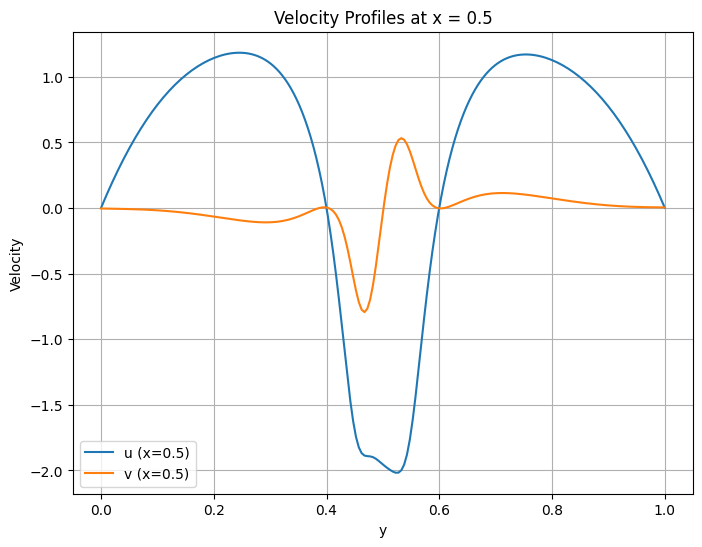

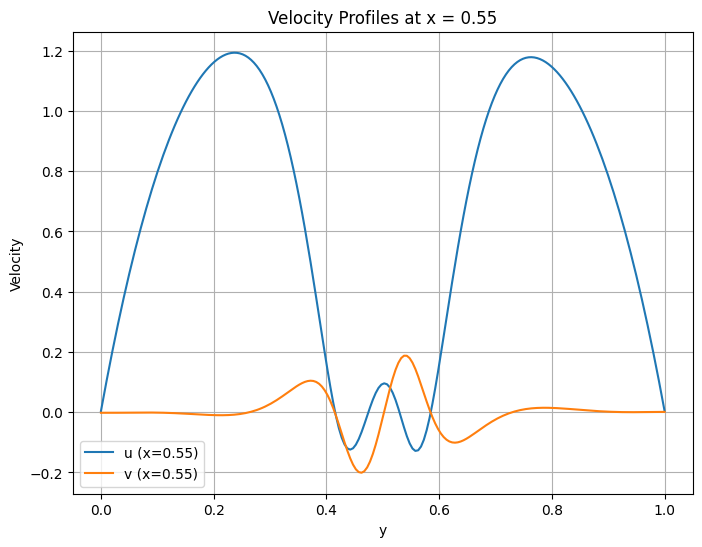

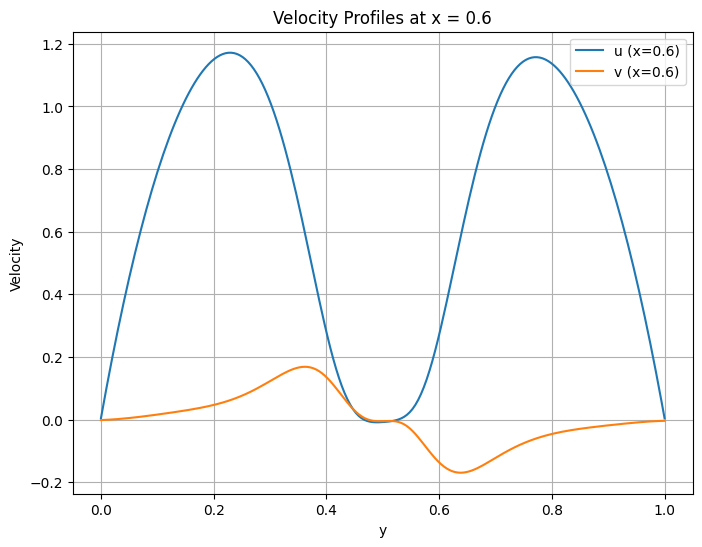

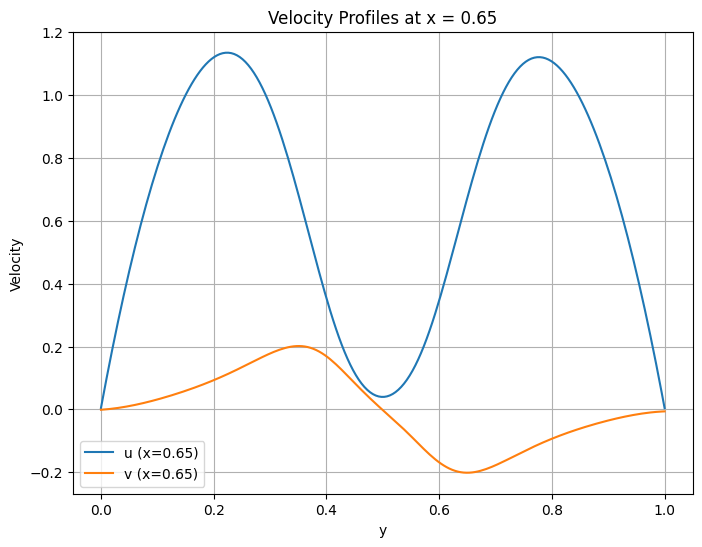

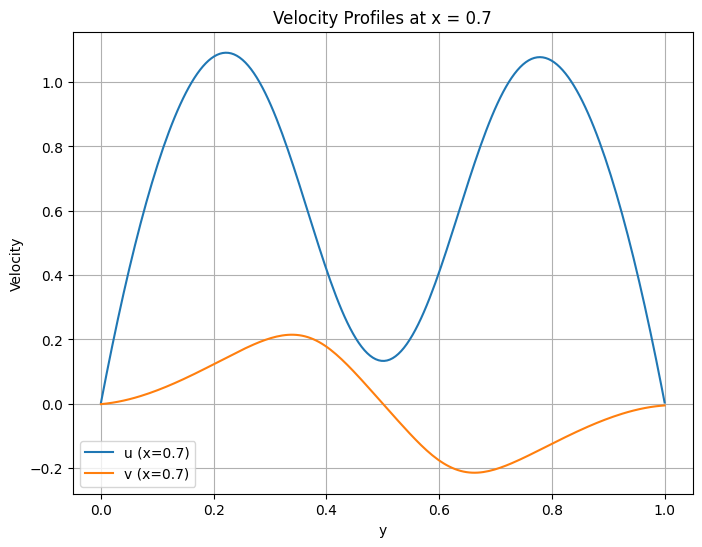

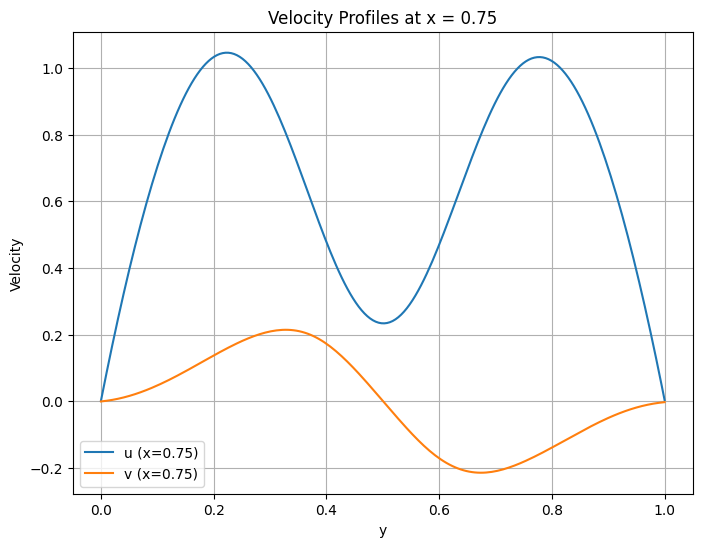

In [36]:
# Plot velocity profiles along specified cross-sections
import pandas as pd
cross_sections = [
    ('x', 0.30),
    ('x', 0.35),
    ('x', 0.40),
    ('x', 0.45),
    ('x', 0.50),
    ('x', 0.55),
    ('x', 0.60),
    ('x', 0.65),
    ('x', 0.70),
    ('x', 0.75),
]
plot_profiles(x, y, u, v, cross_sections, save_csv=True, prefix="u40", location="data/pinn_profiles/")


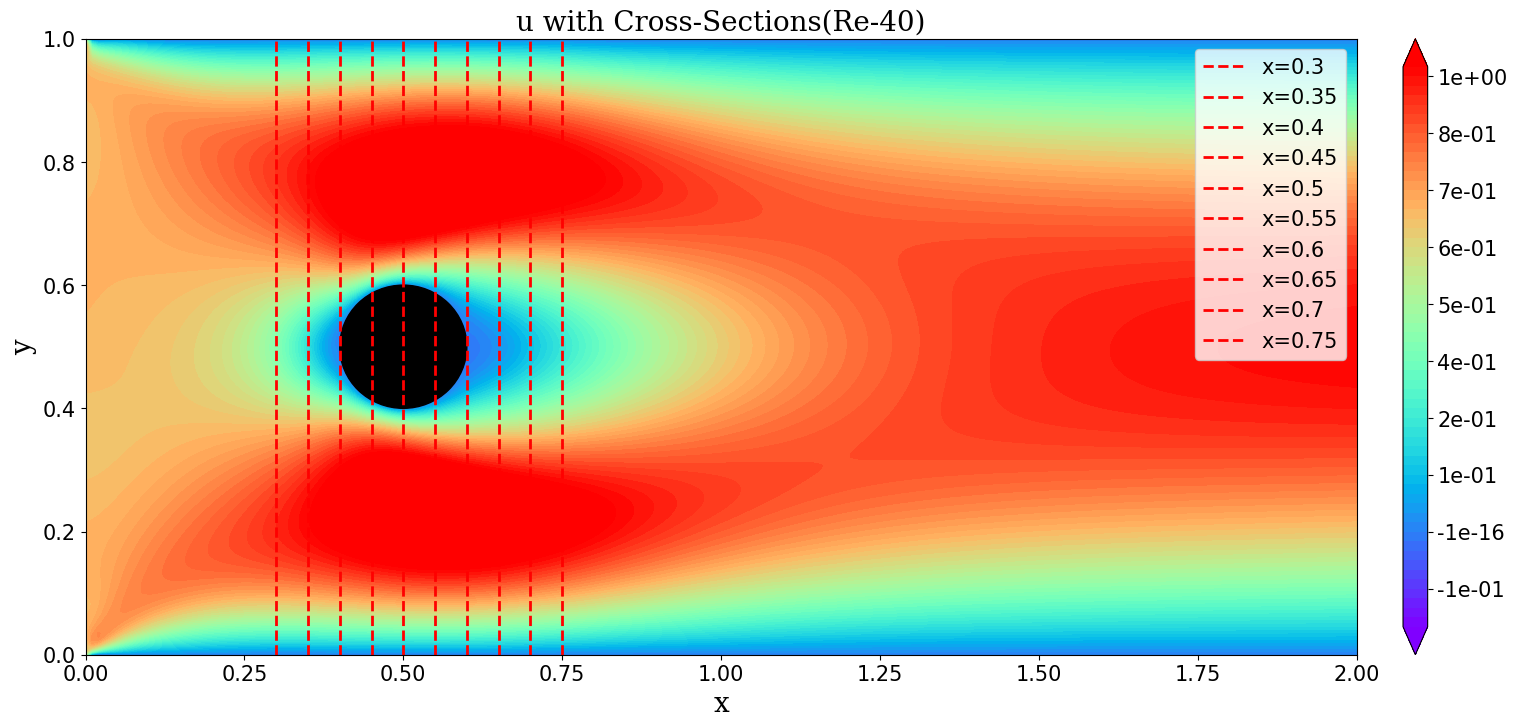

In [39]:


import matplotlib.pyplot as plt
from matplotlib.patches import Circle

font1 = {'family':'serif','size':20}


fig, ax = plt.subplots(1, 1, figsize=(20, 8))
cf = ax.contourf(x, y, u, np.arange(-0.2, 1, .02), extend='both', cmap='rainbow')
cbar = plt.colorbar(cf, pad=0.03, aspect=25, format='%.0e')
# ax.plot([x.min(), x.max(), x.max(), x.min(), x.min()],
#         [y.min(), y.min(), y.max(), y.max(), y.min()],
#         color='black', linewidth=2, label='Domain Boundary')

ax.add_patch(Circle((0.5, 0.5), 0.1, color="black"))

# Overlay cross-section lines
for section in cross_sections:
    section_type, value = section
    if section_type == 'x':
        ax.axvline(value, color='red', linestyle='--', linewidth=2, label=f'x={value}')
    elif section_type == 'y':
        ax.axhline(value, color='blue', linestyle='--', linewidth=2, label=f'y={value}')

# Optional: avoid duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=15)

plt.title("u with Cross-Sections(Re-40)", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
cbar.ax.tick_params(labelsize=15)
plt.savefig("u_with_cross_sections_40.png", dpi=300, bbox_inches='tight')

plt.show()

In [20]:
! pip install pandas

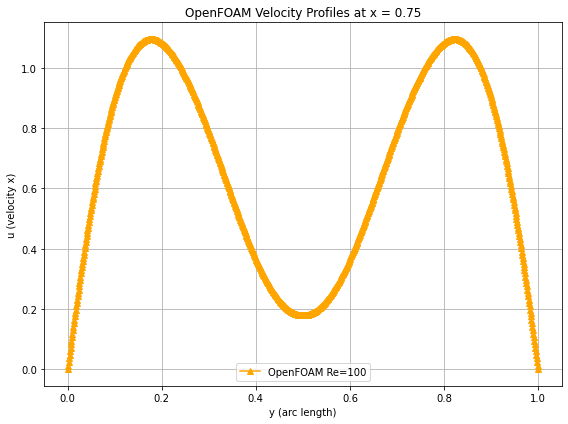

In [25]:

import pandas as pd

# ux_re10 = r"C:\Projects\SoftwareLab_SS25\Navier_Stokes_cylinder2D\data\Re10_Med_Ux\Re10_Med_Ux_0.75.csv"
ux_re100 = r"C:\Projects\SoftwareLab_SS25\Navier_Stokes_cylinder2D\data\Re100_Med_Ux\Re100_Med_Ux_0.75.csv"
# ux_re1000 = r"C:\Projects\SoftwareLab_SS25\Navier_Stokes_cylinder2D\data\Re1000_Med_Ux\Re1000_Med_Ux_0.75.csv"

# Read CSVs (assume columns: arc_length, U_X)
# df_re10 = pd.read_csv(ux_re10)
df_re100 = pd.read_csv(ux_re100)
# df_re1000 = pd.read_csv(ux_re1000)

# Plot OpenFOAM velocity profiles at x=0.75 for different Reynolds numbers
plt.figure(figsize=(8, 6))
# plt.plot(df_re10["arc_length"], df_re10["U_X"], label="OpenFOAM Re=10", color="green", marker="o")
plt.plot(df_re100["arc_length"], df_re100["U_X"], label="OpenFOAM Re=100", color="orange", marker="^")
# plt.plot(df_re1000["arc_length"], df_re1000["U_X"], label="OpenFOAM Re=1000", color="red", marker="s")
plt.xlabel("y (arc length)")
plt.ylabel("u (velocity x)")
plt.title("OpenFOAM Velocity Profiles at x = 0.75")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

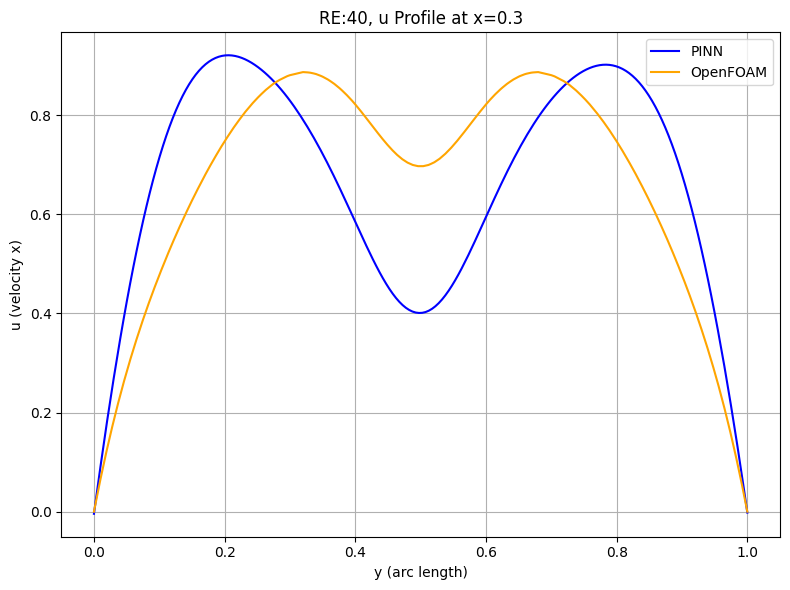

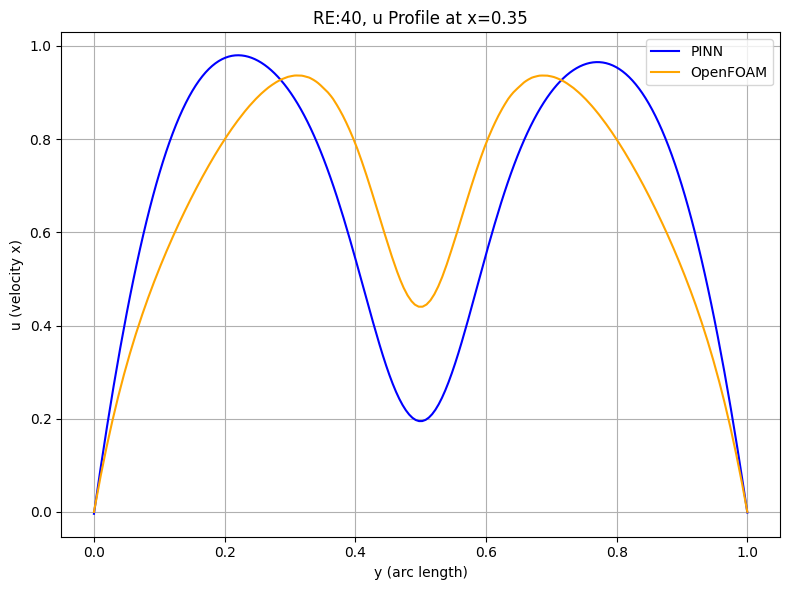

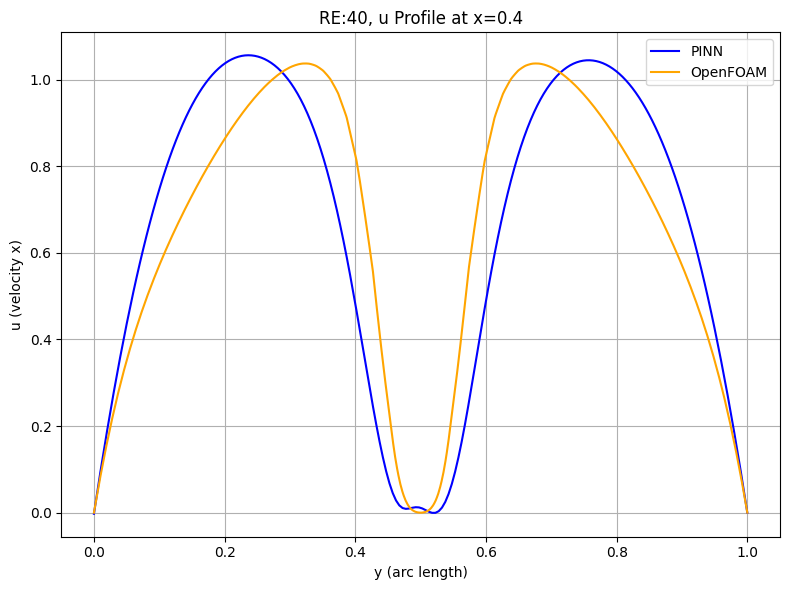

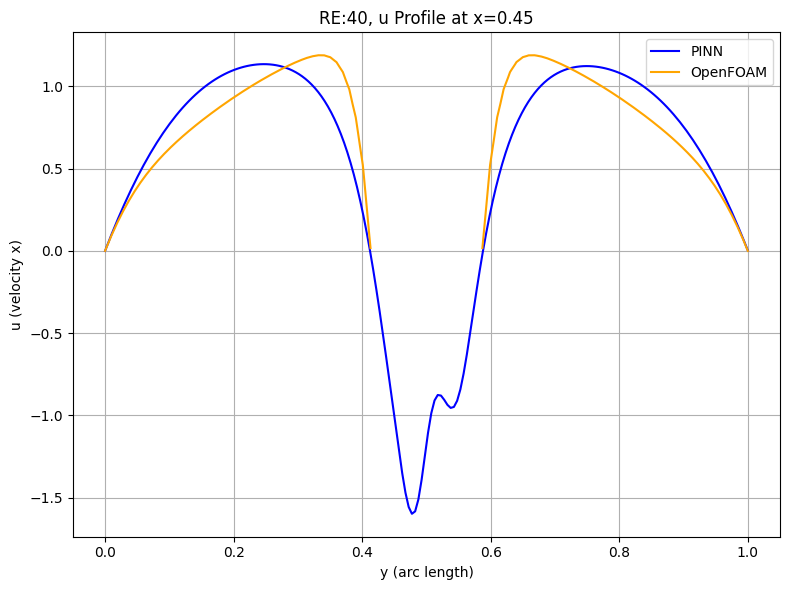

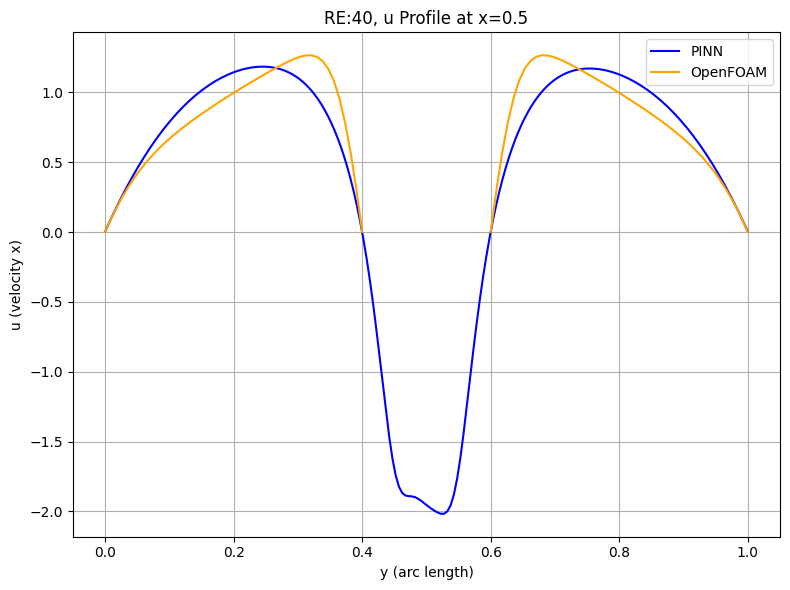

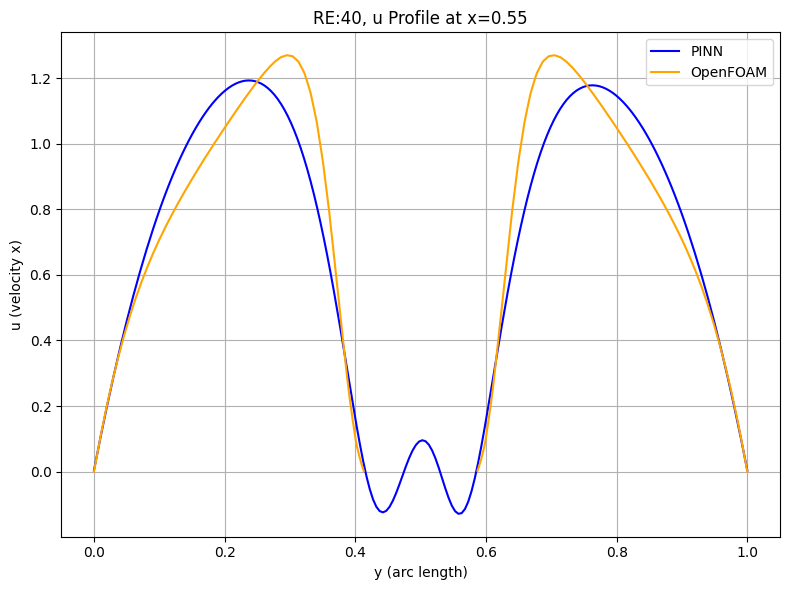

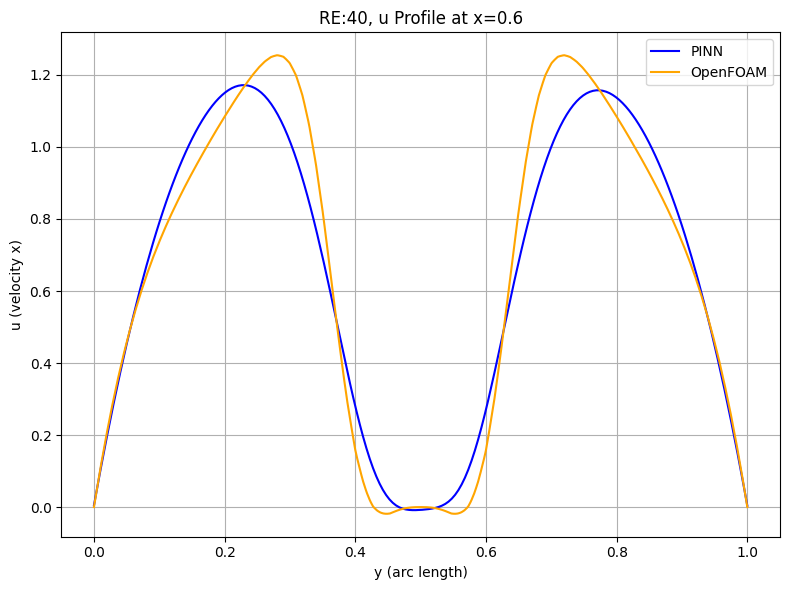

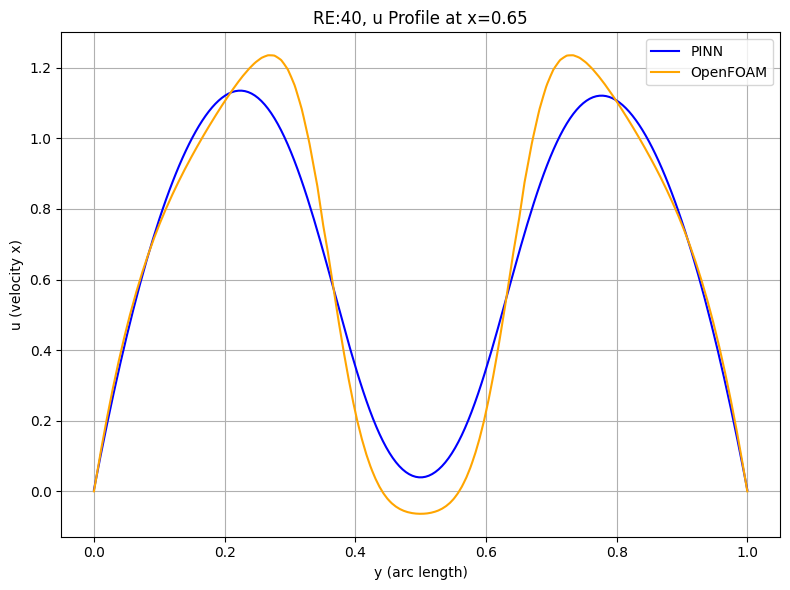

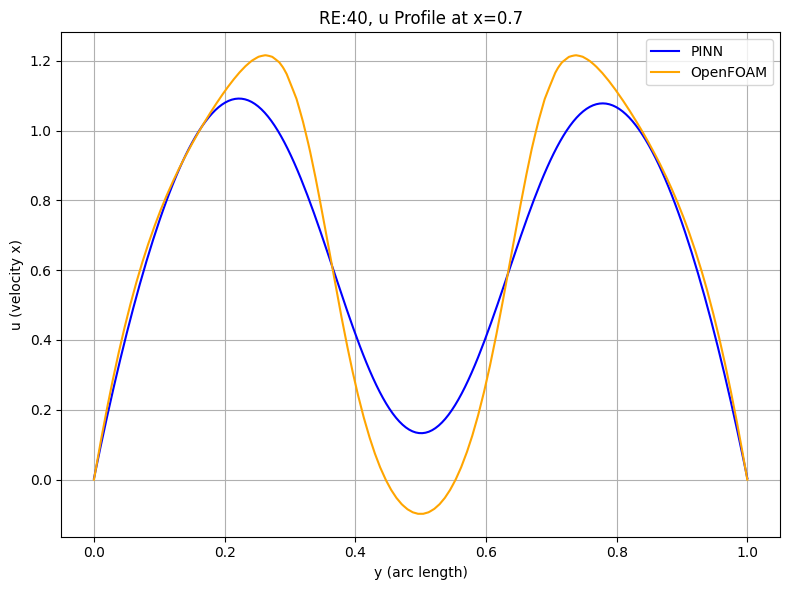

Reference file not found: data/Re40_coarse_cs/Re40_coarse_0.75.csv


In [24]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_profile_comparison(y_pinn, u_pinn, y_ref, u_ref, label_pinn="PINN", label_ref="OpenFOAM", title="Velocity Profile Comparison"):
    """
    Plot and compare two velocity profiles along the same cross-section.
    Args:
        y_pinn: y-coordinates for PINN data.
        u_pinn: velocity values for PINN data.
        y_ref: y-coordinates for reference data (e.g., OpenFOAM).
        u_ref: velocity values for reference data.
        label_pinn: label for PINN data.
        label_ref: label for reference data.
        title: plot title.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(y_pinn, u_pinn, label=label_pinn, color='blue')
    plt.plot(y_ref, u_ref, label=label_ref, color='orange')
    plt.xlabel('y (arc length)')
    plt.ylabel('u (velocity x)')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


# List of cross-sections of interest
cross_sections = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

for x_target in cross_sections:
    idx = np.argmin(np.abs(x[0, :] - x_target))
    y_pinn = y[:, idx]
    u_pinn = u[:, idx]
    # Load OpenFOAM reference data for this cross-section
    # Assumes file naming: data/Re10_cs/Re10_coarse_{x_target}.csv
    fname = f"data/Re40_coarse_cs/Re40_coarse_{x_target}.csv"
    try:
        df_re = pd.read_csv(fname)
        y_ref = df_re["arc_length"]
        u_ref = df_re["U_X"]
        plot_profile_comparison(
            y_pinn, u_pinn, y_ref, u_ref,
            label_pinn="PINN",
            label_ref="OpenFOAM",
            title=f"RE:40, u Profile at x={x_target}"
        )
    except FileNotFoundError:
        print(f"Reference file not found: {fname}")

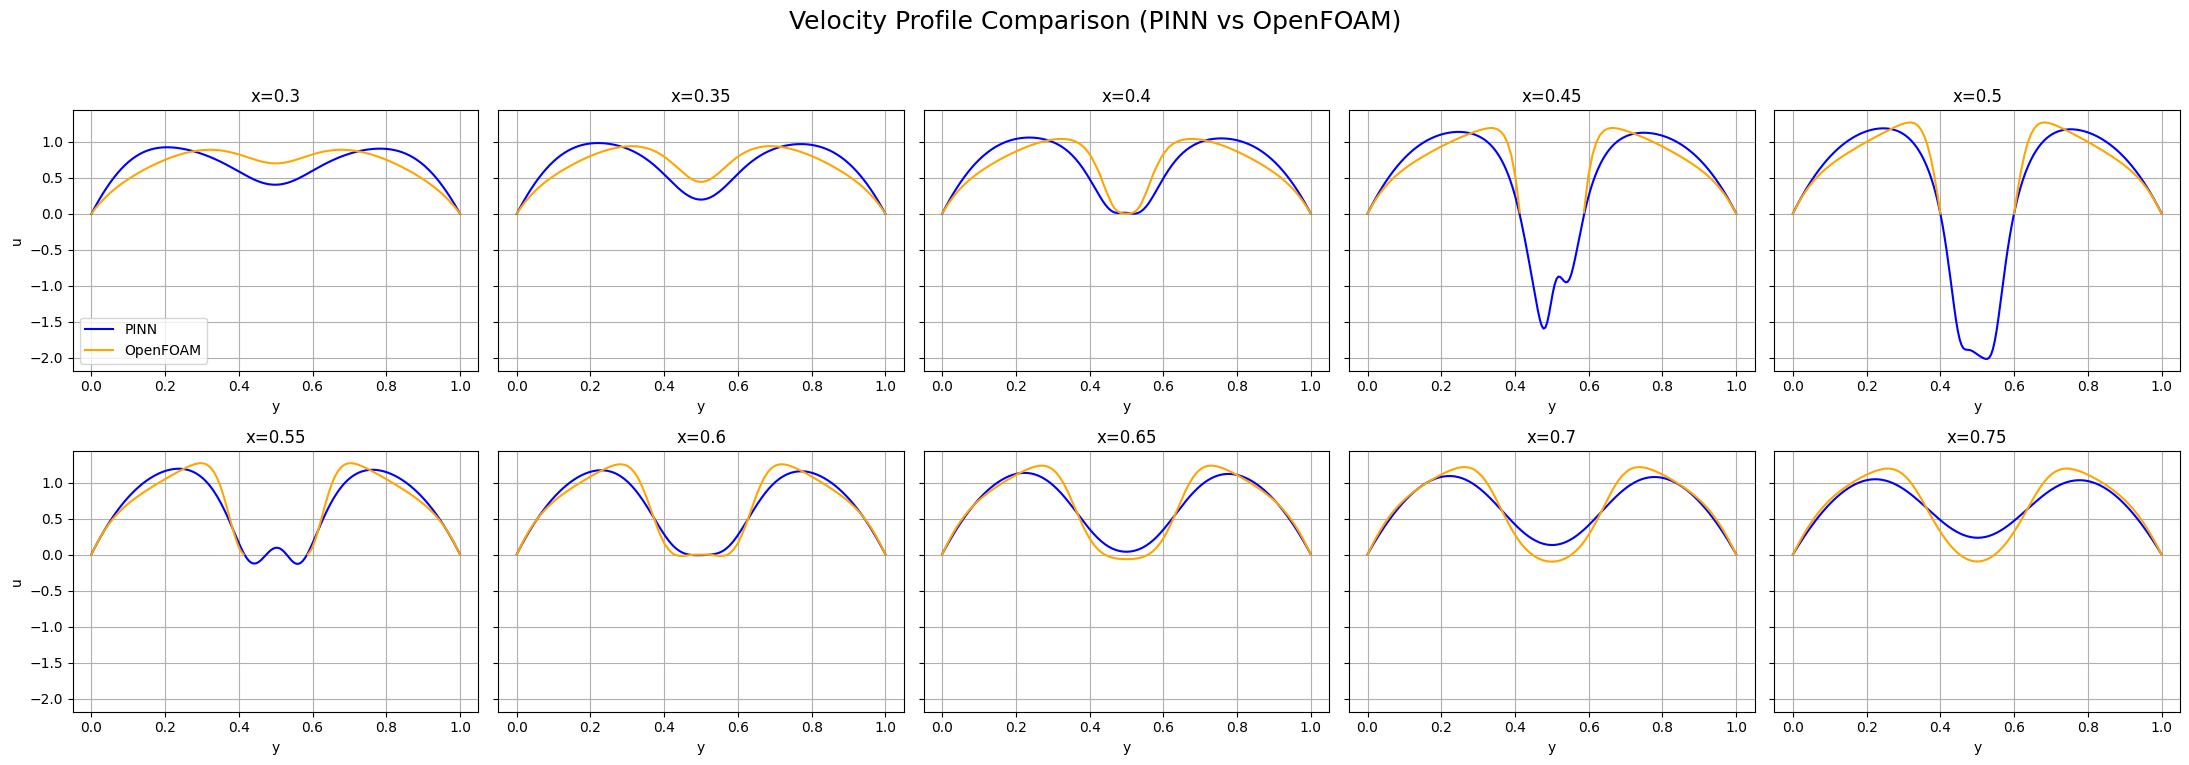

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

cross_sections = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
fig, axes = plt.subplots(2, 5, figsize=(22, 8), sharey=True)
axes = axes.flatten()

for i, x_target in enumerate(cross_sections):
    idx = np.argmin(np.abs(x[0, :] - x_target))
    y_pinn = y[:, idx]
    u_pinn = u[:, idx]
    fname = f"data/Re40_coarse_cs/Re40_coarse_{x_target}.csv"
    try:
        df_re = pd.read_csv(fname)
        y_ref = df_re["arc_length"]
        u_ref = df_re["U_X"]
        axes[i].plot(y_pinn, u_pinn, label="PINN", color='blue')
        axes[i].plot(y_ref, u_ref, label="OpenFOAM", color='orange')
        axes[i].set_title(f"x={x_target}")
        axes[i].set_xlabel("y")
        if i % 5 == 0:
            axes[i].set_ylabel("u")
        axes[i].grid()
        if i == 0:
            axes[i].legend()
    except FileNotFoundError:
        axes[i].set_title(f"x={x_target}\nNo ref data")
        axes[i].set_xlabel("y")
        if i % 5 == 0:
            axes[i].set_ylabel("u")
        axes[i].grid()

plt.suptitle("Velocity Profile Comparison (PINN vs OpenFOAM)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("profile_comparison_40.png", dpi=300)  # Save as high-res image
plt.show()

In [37]:
import numpy as np
from scipy.interpolate import interp1d

# y_pinn, u_pinn: PINN y and u values at x=0.75
# y_ref, u_ref: OpenFOAM y and u values at x=0.75

# Interpolate PINN profile onto OpenFOAM's y-coordinates
u_pinn_interp = interp1d(y_pinn, u_pinn, kind='linear', bounds_error=False, fill_value='extrapolate')
u_pinn_on_ref = u_pinn_interp(y_ref)

# Compute errors
mae = np.mean(np.abs(u_pinn_on_ref - u_ref))
rmse = np.sqrt(np.mean((u_pinn_on_ref - u_ref)**2))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.0741
RMSE: 0.0903


In [32]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

cross_sections = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
results = []

for x_target in cross_sections:
    idx = np.argmin(np.abs(x[0, :] - x_target))
    y_pinn = y[:, idx]
    u_pinn = u[:, idx]
    fname = f"data/Re10_cs/Re10_coarse_{x_target}.csv"
    try:
        df_re = pd.read_csv(fname)
        y_ref = df_re["arc_length"]
        u_ref = df_re["U_X"]
        # Interpolate PINN profile onto OpenFOAM's y-coordinates
        u_pinn_interp = interp1d(y_pinn, u_pinn, kind='linear', bounds_error=False, fill_value='extrapolate')
        u_pinn_on_ref = u_pinn_interp(y_ref)
        # Compute errors
        mae = np.mean(np.abs(u_pinn_on_ref - u_ref))
        rmse = np.sqrt(np.mean((u_pinn_on_ref - u_ref)**2))
        results.append({'cs': x_target, 'mae': mae, 'rmse': rmse})
    except FileNotFoundError:
        results.append({'cs': x_target, 'mae': np.nan, 'rmse': np.nan})

# Create and display table
df_results = pd.DataFrame(results)
print(df_results)

     cs       mae      rmse
0  0.30  0.136180  0.150163
1  0.35  0.111169  0.121765
2  0.40  0.084424  0.096820
3  0.45  0.071235  0.081116
4  0.50  0.047781  0.055446
5  0.55  0.027798  0.034631
6  0.60  0.018148  0.024958
7  0.65  0.021634  0.025752
8  0.70  0.026311  0.029829
9  0.75  0.029056  0.033258


In [33]:
df_results.describe()

,cs,mae,rmse
count,10.000000,10.000000,10.000000
mean,0.525000,0.057374,0.065374
std,0.151383,0.041604,0.044904
min,0.300000,0.018148,0.024958
25%,0.412500,0.026683,0.030686
50%,0.525000,0.038419,0.045038
75%,0.637500,0.081127,0.092894
max,0.750000,0.136180,0.150163


In [34]:
df_results.to_csv("data/Re40_coarse_errors.csv", index=False)